*Data source:*

- [*FAOSTAT: Food and Agriculture Organization of the United Nations*](https://www.fao.org/faostat/en/#release_calendar)
- [*The world bank*](https://databank.worldbank.org/)
- *https://tradingeconomics.com/country-list/temperature*

**Table of contents**<a id='toc0_'></a>    
1. [Import libraries and other useful code.](#toc1_)    
2. [Read preprocessed datasets.](#toc2_)  
2. [Exploratory Data Analysis](#toc3_) 
3.1. [Crop final dataset](#toc3_1_)  
3.1.1. [``Yield`` variable](#toc3_1_1_)  
3.1.2. [``Area harvested`` variable](#toc3_1_2_)   
3.1.3. [``Production`` variable](#toc3_1_3_)   
3.1.4. [``Area (countries)`` variable](#toc3_1_4_)   
3.1.5. [``Average rainfall`` variable](#toc3_1_5_)   
3.2. [Pesticides dataset](#toc3_2_)    

---
## 1. <a id='toc1_'></a>[Import libraries and other useful code](#toc0_)

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Interactive maps
import folium
from folium import plugins
from folium.plugins import FastMarkerCluster
import geopandas as gpd

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
# define color palette
agro = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']
agro_r = ['#ffe599','#ffd966','#bf9000','#59533e','#4e6f43','#668f4f','#7fa465','#9bc27e','#b2cb91']

In [23]:
sns.set(style="whitegrid")  # Seaborn Grid Style

In [5]:
# Set the display of numbers in decimal notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. <a id='toc2_'></a>[Read preprocessed datasets](#toc0_)

In [99]:
df = pd.read_csv('Data/df_preprocessed.csv')
fert = pd.read_csv('Data/fert_preprocessed.csv')
pest = pd.read_csv('Data/pest_preprocessed.csv')

## 3. <a id='toc3_'></a>[Exploratory Data Analysis](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Crop final dataset](#toc0_)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  62994 non-null  object 
 1   Crop                  62994 non-null  object 
 2   Year                  62994 non-null  int64  
 3   area_harvested_ha     62994 non-null  float64
 4   production_tonnes     62994 non-null  float64
 5   yield_hg/ha           62994 non-null  float64
 6   avg_rainfall_mm_year  62994 non-null  float64
 7   avg_temp_ºC           62994 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.8+ MB


In [8]:
df.describe(include='object')

,Area,Crop
count,62994,62994
unique,172,50
top,China,"Other vegetables, fresh n.e.c."
freq,650,2109


In [9]:
# convert year to object type, because it's discrete.
df['Year'] = df['Year'].astype(object)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
area_harvested_ha,62994.00,236013.04,1693645.75,1.00,776.00,5380.00,37686.00,46400000.00
production_tonnes,62994.00,1568997.08,15294195.88,0.06,4813.00,41476.50,281000.00,768594154.00
yield_hg/ha,62994.00,156064.48,326611.04,39.00,26867.00,79277.00,184766.00,8755278.00
avg_rainfall_mm_year,62994.00,1118.02,765.26,18.10,562.00,1026.00,1622.00,3240.00
avg_temp_ºC,62994.00,19.54,7.48,-3.96,12.43,22.01,25.56,29.65


In [11]:
df.head(2)

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
0,Afghanistan,Wheat,2010,2354000.00,4532000.00,19252.00,327.00,14.38
1,Afghanistan,Wheat,2011,2232000.00,3388000.00,15179.00,327.00,14.38


In [9]:
df_corr = df.copy()

In [10]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  62994 non-null  object 
 1   Crop                  62994 non-null  object 
 2   Year                  62994 non-null  int64  
 3   area_harvested_ha     62994 non-null  float64
 4   production_tonnes     62994 non-null  float64
 5   yield_hg/ha           62994 non-null  float64
 6   avg_rainfall_mm_year  62994 non-null  float64
 7   avg_temp_ºC           62994 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.8+ MB


In [11]:
# encode the object type variables to analize the correlation

from sklearn.preprocessing import LabelEncoder

# create an instance of the encoder
encoder = LabelEncoder() 
# Fit and transform the LabelEncoder on the column
for columns in df_corr.columns:
    if df_corr[columns].dtype == 'object':
        df_corr[columns] = encoder.fit_transform(df_corr[columns])

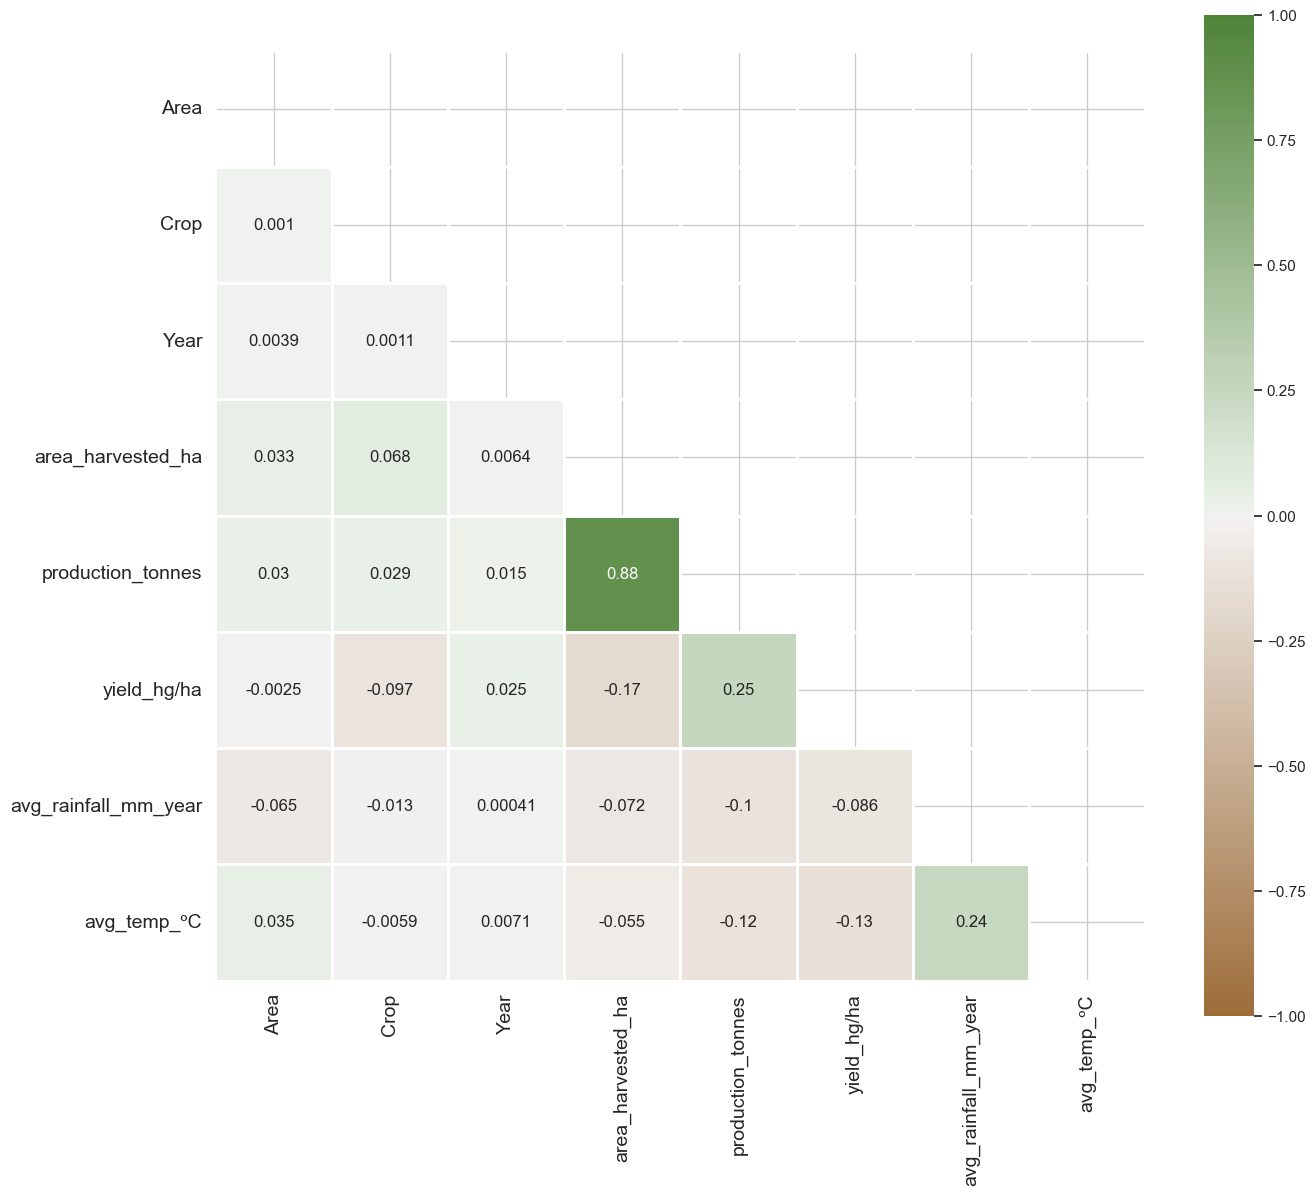

In [14]:
# Spearman's method 
corr = df_corr.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool)) 
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(45, 120, s=75, l=50, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask[0:9,0:9], cmap=cmap, vmax=1, center=0, vmin=-1,  
            square=True, linewidths=1, cbar_kws={"shrink": 1}, annot = True) 

# Adjust x and y axis font size
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)     

#### 3.1.1 <a id='toc3_1_1_'></a>[``Yield`` variable](#toc0_)

In [19]:
yieldbyyear = df.groupby('Year')['yield_hg/ha'].mean() # Groups the df by the year and calculates the average of the column 'yield_hg/ha' for each year.

# Plotly Graph
fig = go.Figure(data=go.Scatter(x=yieldbyyear.index, y=yieldbyyear.values, line=dict(color=agro[3])))

fig.update_layout(xaxis_title='Year', yaxis_title='Average Yield (hg/ha)', title='Average Yield per Year',width=600, height=400,xaxis=dict(tickmode='linear', dtick=1),title_x=0.5) 

fig.show()

In [17]:
max_yield = df['yield_hg/ha'].max()
df[df['yield_hg/ha']==max_yield]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
42369,Oman,Cucumbers and gherkins,2010,36.00,31519.00,8755278.00,125.00,28.02


In [18]:
min_yield = df['yield_hg/ha'].min()
df[df['yield_hg/ha']==min_yield]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
40423,New Caledonia,Other pulses n.e.c.,2017,360.00,1.40,39.00,1171.86,23.23


In [19]:
# Average yield for each crop over all years
crops_byyield = df.groupby('Crop')['yield_hg/ha'].mean().sort_values(ascending=False).reset_index()

In [20]:
fig = px.bar(crops_byyield, x='yield_hg/ha', y='Crop', color='yield_hg/ha', color_continuous_scale=agro)
fig.update_layout(height=1000, width=1500, title_text="Top 20 crops by average yield (hg/ha)", title_x=0.5,xaxis_title='average yield (hg/ha)',yaxis_title = '',
                  coloraxis_colorbar_title='average yield (hg/ha)') 

fig.show()

#### 3.1.2. <a id='toc3_1_2_'></a>[``Area harvested`` variable](#toc0_)

<Axes: xlabel='Year'>

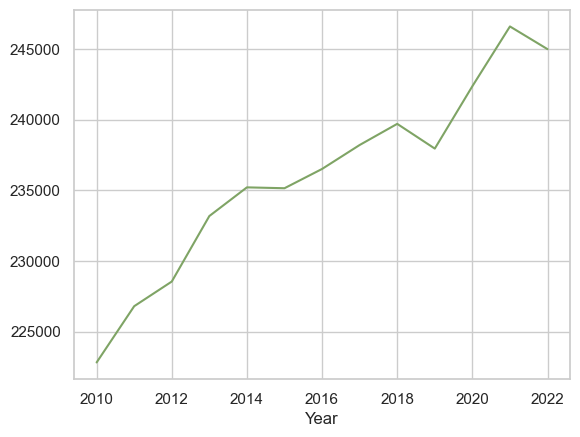

In [21]:
df.groupby('Year')['area_harvested_ha'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'area_harvested_ha' for each year.

In [22]:
max_area= df['area_harvested_ha'].max()
df[df['area_harvested_ha']==max_area]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
25635,India,Rice,2022,46400000.00,196245700.00,42294.00,1083.00,25.14


In [23]:
min_area = df['area_harvested_ha'].min()
df[df['area_harvested_ha']==min_area]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
1596,Antigua and Barbuda,Cabbages,2020,1.00,1.80,13846.00,1030.00,27.20
1678,Antigua and Barbuda,"Onions and shallots, dry (excluding dehydrated)",2021,1.00,5.05,83609.00,1030.00,27.20
1700,Antigua and Barbuda,Carrots and turnips,2017,1.00,11.42,127666.00,1030.00,27.20
1703,Antigua and Barbuda,Carrots and turnips,2020,1.00,15.00,214286.00,1030.00,27.20
1786,Antigua and Barbuda,Pineapples,2022,1.00,1.34,15855.00,1030.00,27.20
...,...,...,...,...,...,...,...,...
57037,Turkey,Sorghum,2016,1.00,3.00,30000.00,593.00,12.42
57038,Turkey,Sorghum,2017,1.00,3.00,30000.00,593.00,12.42
57039,Turkey,Sorghum,2018,1.00,3.00,30000.00,593.00,12.42
57040,Turkey,Sorghum,2019,1.00,4.00,40000.00,593.00,12.42


In [24]:
# Average area harvested for each crop over all years
crops_byarea = df.groupby('Crop')['area_harvested_ha'].mean().sort_values(ascending=False).reset_index()

In [25]:
fig = px.bar(crops_byarea, x='area_harvested_ha', y='Crop', color='area_harvested_ha', color_continuous_scale=agro)
fig.update_layout(height=1000, width=1500, title_text="Top 20 crops by average area (ha)", title_x=0.5,xaxis_title='average area (ha)',yaxis_title = '',
                  coloraxis_colorbar_title='average area (ha)')  

#### 3.1.3. <a id='toc3_1_3_'></a>[``Production`` variable](#toc0_)

<Axes: xlabel='Year'>

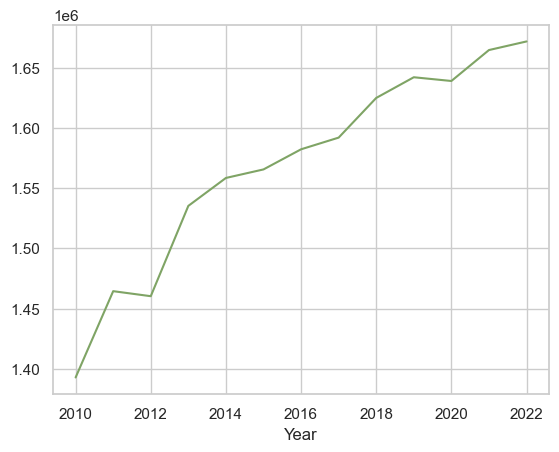

In [26]:
df.groupby('Year')['production_tonnes'].mean().plot(color=agro[2]) # Groups the df by the year and calculates the average of the column 'production_tonnes' for each year.

In [27]:
max_production= df['production_tonnes'].max()
df[df['production_tonnes']==max_production]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
8185,Brazil,Sugar cane,2016,10223894.00,768594154.00,751763.00,1761.00,25.56


In [28]:
min_production = df['production_tonnes'].min()
df[df['production_tonnes']==min_production]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
40427,New Caledonia,Other pulses n.e.c.,2021,6.00,0.06,107.00,1171.86,23.23


In [29]:
# Average production for each crop over all years
crops_byproduction = df.groupby('Crop')['production_tonnes'].mean().sort_values(ascending=False).reset_index()

In [30]:
fig = px.bar(crops_byproduction, x='production_tonnes', y='Crop', color='production_tonnes', color_continuous_scale=agro)
fig.update_layout(height=1000, width=1500, title_text="Top 20 crops by production (tonnes)", title_x=0.5,xaxis_title='average production (tonnes)',yaxis_title = '',
                  coloraxis_colorbar_title='average production (tonnes)')  

#### 3.1.4 <a id='toc3_1_4_'></a>[``Area (countries)`` variable](#toc0_)

- INTERACTIVE MAPS

In [32]:
map_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"

In [33]:
geo = gpd.read_file(map_url)

In [34]:
geo = geo[['SOVEREIGNT','geometry']].copy()
# change the name to the column 'name'
geo.columns = ['Area','geometry']

In [35]:
geo.isnull().sum() 

Area        0
geometry    0
dtype: int64

In [36]:
geo.shape

(177, 2)

In [37]:
# correction of country names
geo['Area'].replace('United States of America','United States', inplace=True)
geo['Area'].replace('United Republic of Tanzania','Tanzania', inplace=True)
geo['Area'].replace('Czechia','Czech Republic', inplace=True)
geo['Area'].replace('Republic of Serbia','Serbia', inplace=True)

In [38]:
# Average area harvested by Country over all years
country_byarea = df.groupby('Area')['area_harvested_ha'].mean().sort_values(ascending=True).reset_index()
# Average yield by Country over all years
country_byyield = df.groupby('Area')['yield_hg/ha'].mean().sort_values(ascending=True).reset_index()
# Average rain by Country over all years
rain_byarea = df.groupby('Area')['avg_rainfall_mm_year'].mean().sort_values(ascending=True).reset_index()

In [39]:
# create a new df called geo1 with the geo information and the average harvested area per country, using the country column as common.
geo1 = pd.merge(geo, country_byarea[['Area', 'area_harvested_ha']], on='Area', how='inner') 
# create a new df called geo2 with the geo information and the average yield per country, using the country column as common.
geo2 = pd.merge(geo1, country_byyield[['Area', 'yield_hg/ha']], on='Area', how='inner') 
# create a new df called geo_final with the geo information and the average rainfall, using the country column as common.
geo_final = pd.merge(geo2, rain_byarea[['Area', 'avg_rainfall_mm_year']], on='Area', how='inner')

In [40]:
geo_final.shape

(158, 5)

In [41]:
# Save final df in csv:
geo_final.to_csv('geo_final.csv', index=False)

In [42]:
geo_final.head(2)

,Area,geometry,area_harvested_ha,yield_hg/ha,avg_rainfall_mm_year
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2387.10,96587.09,2592.00
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",340957.39,72854.03,1071.00


In [43]:
# Create the Folium map with the specified initial location
m = folium.Map(location=[43.037332, -40.410610],zoom_start=2)

# 1- average area harvested per country
# Create an instance of folium.Choropleth
area = folium.Choropleth(geo_final, data=geo_final, fill_color = 'YlGn',columns=['Area','area_harvested_ha'],key_on='feature.properties.Area',name='avg harvested area')

# Add the instance of folium.Choropleth to the map m
area.add_to(m)

# Define the tooltip content (what is displayed when the cursor is placed over it)
tooltip_area = folium.GeoJsonTooltip(fields=['Area', 'area_harvested_ha'], 
                                 aliases=['Country', 'avg harvested area (ha)'],
                                 labels=True,
                                 sticky=False) 

area.geojson.add_child(tooltip_area)

#-----------------------------------------

# 2- average yield per country
# Create an instance of folium.Choropleth
avg_yield = folium.Choropleth(geo_final, data=geo_final, fill_color = 'YlGn',columns=['Area','yield_hg/ha'],key_on='feature.properties.Area',name='avg crop yield')

# Add the instance of folium.Choropleth to the map m
avg_yield.add_to(m)

# Define the tooltip content (what is displayed when the cursor is placed over it)
tooltip_yield = folium.GeoJsonTooltip(fields=['Area', 'yield_hg/ha'], 
                                 aliases=['Country', 'avg crop yield (hg/ha)'],
                                 labels=True,
                                 sticky=False) 

avg_yield.geojson.add_child(tooltip_yield)

#-----------------------------------------

# 3- average rainfall per country
# Create an instance of folium.Choropleth
avg_rain = folium.Choropleth(geo_final, data=geo_final, fill_color = 'YlGn',columns=['Area','avg_rainfall_mm_year'],key_on='feature.properties.Area',name='avg rainfall')

# Add the instance of folium.Choropleth to the map m
avg_rain.add_to(m)

# Define the tooltip content (what is displayed when the cursor is placed over it)
tooltip_rain = folium.GeoJsonTooltip(fields=['Area', 'avg_rainfall_mm_year'], 
                                 aliases=['Country', 'avg rainfall per year (mm)'],
                                 labels=True,
                                 sticky=False) 

avg_rain.geojson.add_child(tooltip_rain)


# Add a layer control
folium.LayerControl().add_to(m) 

folium.LayerControl({'avg harvested area (ha)':area.layer_name,'avg crop yield (hg/ha)': avg_yield.layer_name, 'avg raindall per year (mm)':avg_rain.layer_name}).add_to(m)
m

In [127]:
# improvement: some countries are missing: south sudan, slovakia, serbia, moldavia, kirgistan

In [44]:
# save html map
m.save('html/agromap.html')

#### 3.1.5. <a id='toc3_1_5_'></a>[``Average rainfall`` variable](#toc0_)

In [49]:
geo_final.head(2)

,Area,geometry,area_harvested_ha,yield_hg/ha,avg_rainfall_mm_year
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",2387.10,96587.09,2592.00
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",340957.39,72854.03,1071.00


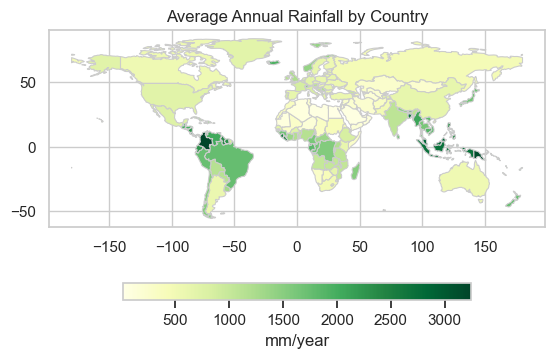

In [45]:
ax = geo_final.plot(column='avg_rainfall_mm_year', cmap='YlGn', linewidth=0.8, edgecolor='0.8')
plt.title("Average Annual Rainfall by Country")
# set colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=geo_final['avg_rainfall_mm_year'].min(), vmax=geo_final['avg_rainfall_mm_year'].max()))
cbar = plt.colorbar(sm, ax=ax, label='mm/year', orientation='horizontal',shrink=0.7)
plt.show()

In [46]:
# Average rain fall for each area over all years
area_byrain = df.groupby('Area')['avg_rainfall_mm_year'].mean().sort_values(ascending=False).reset_index()
top_20areas_byrain= area_byrain.head(20)
least_20areas_byrain= area_byrain.tail(20)

In [47]:
fig = px.bar(top_20areas_byrain, x='avg_rainfall_mm_year', y='Area', color='avg_rainfall_mm_year', color_continuous_scale=agro)
fig.update_layout(height=500, width=1500, title_text="Top 20 countries by average rain (mm)", title_x=0.5,xaxis_title='average rain (mm)',yaxis_title = '',
                  coloraxis_colorbar_title='average rain (mm)')  

In [48]:
fig = px.bar(least_20areas_byrain, x='avg_rainfall_mm_year', y='Area', color='avg_rainfall_mm_year', color_continuous_scale=agro)
fig.update_layout(height=500, width=1500, title_text="Least 20 countries by average rain (mm)", title_x=0.5,xaxis_title='average rain (mm)',yaxis_title = '',
                  coloraxis_colorbar_title='average rain (mm)')  

### 3.2. <a id='toc3_2_'></a>[Pesticides dataset](#toc0_)

In [100]:
pest.shape

(12373, 4)

In [101]:
pest.head()

,Area,pesticides_type,Year,agricultural_use_tonnes
0,Albania,Insecticides,2010,375.80
1,Albania,Insecticides,2011,317.07
2,Albania,Insecticides,2012,157.57
3,Albania,Insecticides,2013,214.13
4,Albania,Insecticides,2014,34.48


#### 3.2.1. <a id='toc3_2_1_'></a>[Merge datasets](#toc0_)

##### 3.2.1.1. <a id='toc3_2_1_1_'></a>[avg pesticides use & avg yield by **Area** and **Year**](#toc0_)

In [102]:
# group crop df by area and year
yieldgroupbyarea_year = df.groupby(['Area','Year'])['yield_hg/ha'].mean().reset_index()
# group pest df by area and year
pestgroupbyarea_year = pest.groupby(['Area','Year'])['agricultural_use_tonnes'].mean().reset_index()
# merge both df
pest_crops = pestgroupbyarea_year.merge(yieldgroupbyarea_year, on=['Area','Year'], how='inner')

In [103]:
pest_crops

,Area,Year,agricultural_use_tonnes,yield_hg/ha
0,Albania,2010,97.12,137694.69
1,Albania,2011,95.59,156311.71
2,Albania,2012,58.46,164927.00
3,Albania,2013,73.20,161390.37
4,Albania,2014,74.45,158504.29
...,...,...,...,...
1949,Zimbabwe,2017,334.82,65100.04
1950,Zimbabwe,2018,334.82,66668.16
1951,Zimbabwe,2019,334.82,65884.33
1952,Zimbabwe,2020,334.82,66512.36


In [104]:
# Save to csv:
pest_crops.to_csv('Data/pest_crops.csv', index=False)

In [105]:
pest_crops.isnull().sum()

Area                       0
Year                       0
agricultural_use_tonnes    0
yield_hg/ha                0
dtype: int64

In [106]:
pestbyyear = pest_crops.groupby('Year')['agricultural_use_tonnes'].mean() # Groups the df by the year and calculates the average of the column 'agricultural_use_tonnes' for each year.

# Plotly Graph
fig = go.Figure(data=go.Scatter(x=pestbyyear.index, y=pestbyyear.values, line=dict(color=agro[3])))

fig.update_layout(xaxis_title='Year', yaxis_title='Pesticides use (tonnes)', title='Average pesticides use per Year',width=600, height=400,xaxis=dict(tickmode='linear', dtick=1),title_x=0.5) 

fig.show()

In [107]:
df_corr = pest_crops.copy()

In [108]:
# convert year variable to object type, because it's a discrete variable
df_corr['Year'] = df_corr['Year'].astype(object)

In [109]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     1954 non-null   object 
 1   Year                     1954 non-null   object 
 2   agricultural_use_tonnes  1954 non-null   float64
 3   yield_hg/ha              1954 non-null   float64
dtypes: float64(2), object(2)
memory usage: 61.2+ KB


In [110]:
# encode the object type variables to analize the correlation

from sklearn.preprocessing import LabelEncoder

# create an instance of the encoder
encoder = LabelEncoder() 
# Fit and transform the LabelEncoder on the column
for columns in df_corr.columns:
    if df_corr[columns].dtype == 'object':
        df_corr[columns] = encoder.fit_transform(df_corr[columns])

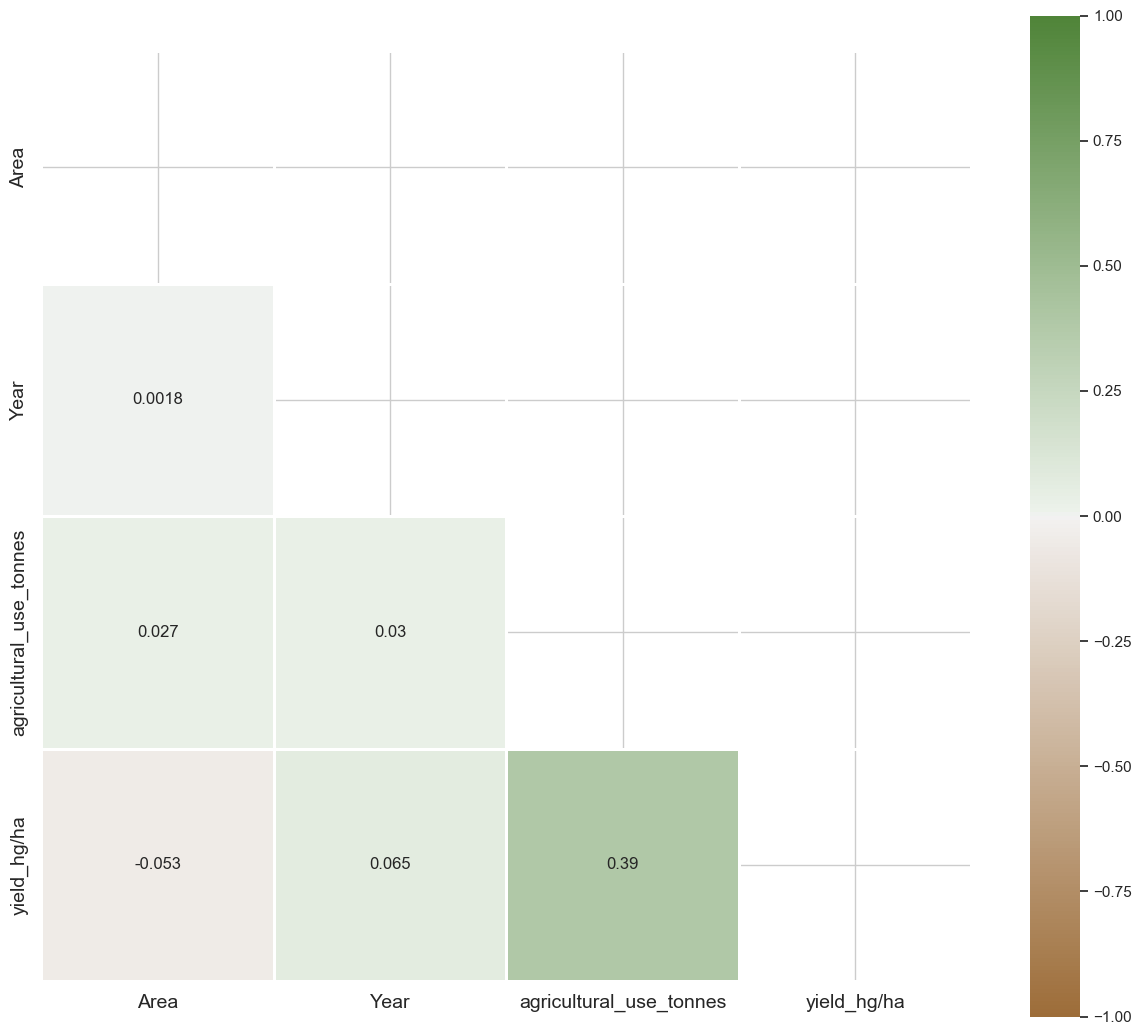

In [111]:
# Spearman's method 
corr = df_corr.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool)) 
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(45, 120, s=75, l=50, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask[0:9,0:9], cmap=cmap, vmax=1, center=0, vmin=-1,  
            square=True, linewidths=1, cbar_kws={"shrink": 1}, annot = True)  
# Adjust x and y axis font size
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)  

There is a moderate positive correlation between the use of pesticides and crop yields.

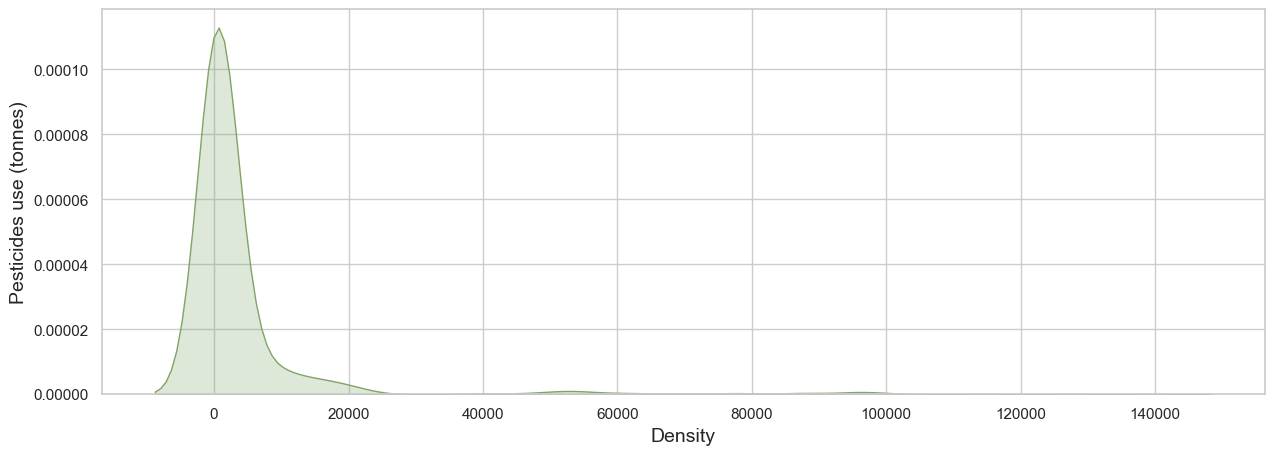

In [112]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=pest_crops, x='agricultural_use_tonnes', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Pesticides use (tonnes)', fontsize=14)
plt.show()

The majority of pesticides quantity is around 0.

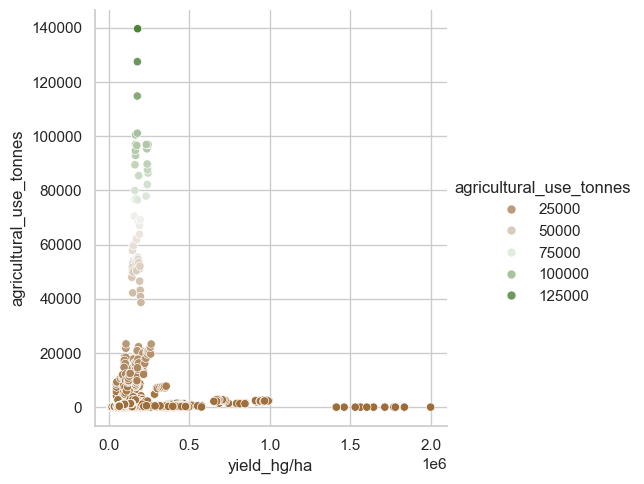

In [113]:
# plot the relationship between 2 continuous variables -> 'yield_hg/ha' and 'agricultural_use_tonnes' -> Target: yield var
# group pest_crops by Areas and do the tonnes and yield mean
sns.relplot(data = pest_crops, x = 'yield_hg/ha', y = 'agricultural_use_tonnes', hue='agricultural_use_tonnes',palette=cmap) 

##### 3.2.1.2. <a id='toc3_2_1_2_'></a>[avg pesticides type by **Area**](#toc0_)

In [114]:
pest_total_area = pest.groupby(['Area','pesticides_type'])['agricultural_use_tonnes'].mean().reset_index()

In [115]:
pest_total_area

,Area,pesticides_type,agricultural_use_tonnes
0,Albania,Fungicides : Seed treatments,0.17
1,Albania,Fungicides and Bactericides,254.68
2,Albania,Herbicides,56.99
3,Albania,Insecticides,181.33
4,Albania,Insecticides : Seed Treatments,9.59
...,...,...,...
1039,Zimbabwe,Fungicides and Bactericides,615.89
1040,Zimbabwe,Herbicides,638.16
1041,Zimbabwe,Insecticides,1057.99
1042,Zimbabwe,Insecticides : Seed Treatments,9.63


In [116]:
# Sort the bars by 'agricultural_use_tonnes'
pest_total_area_sorted = pest_total_area.sort_values(by='agricultural_use_tonnes', ascending=False)

fig = px.bar(
    pest_total_area_sorted,
    x='agricultural_use_tonnes',
    y='pesticides_type',
    color='pesticides_type',  
    color_discrete_sequence=agro_r,  
    labels={'agricultural_use_tonnes': 'Use of pesticides (tonnes)', 'pesticides_type': 'Pesticide type'}
)
fig.update_layout(title='Average pesticides use by type',width=1200, height=500,title_x=0.5) 

fig.show()

In [117]:
pest_total_area

,Area,pesticides_type,agricultural_use_tonnes
0,Albania,Fungicides : Seed treatments,0.17
1,Albania,Fungicides and Bactericides,254.68
2,Albania,Herbicides,56.99
3,Albania,Insecticides,181.33
4,Albania,Insecticides : Seed Treatments,9.59
...,...,...,...
1039,Zimbabwe,Fungicides and Bactericides,615.89
1040,Zimbabwe,Herbicides,638.16
1041,Zimbabwe,Insecticides,1057.99
1042,Zimbabwe,Insecticides : Seed Treatments,9.63


In [118]:
new_palette = ['#BDF08D', '#1D761D','#C0A45E', '#764E1D', '#F5F78E', '#F7CC8E']
fig = px.pie(pest_total_area, values='agricultural_use_tonnes', names='pesticides_type',color_discrete_sequence=new_palette,labels={'agricultural_use_tonnes': 'Use of pesticides (tonnes)', 'pesticides_type': 'Pesticide type'})
fig.update_layout(
    template="plotly_white",
    title="Average pesticides use by type",
    title_x=0.5,
    width=800, height=1000,
    legend=dict(
        orientation='h',  # Orientación horizontal
        y=1,  # Desplazamiento vertical desde el gráfico (0-1)
        xanchor='center',  # Ancla en el centro horizontal
        x=0.5  # Desplazamiento horizontal desde el gráfico (0-1)
    ))

fig.update_traces(textinfo='label+percent', textfont_size=12,text=pest_total_area['pesticides_type'],marker = dict(line = dict(color = 'black', width = 0.5)))
fig.show()


- top countries using pesticides

Which are the countries with the highest levels of pesticide use in tonnes?

In [119]:
top50 = pest_total_area_sorted.head(50)

In [124]:
top50['Area'].replace('TÃ¼rkiye','Turkey',inplace=True)

C:\Users\kina5\AppData\Local\Temp\ipykernel_4924\2075391602.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
fig = px.bar(
    top50,
    y='Area',
    x='agricultural_use_tonnes',
    color='Area',  
    color_discrete_sequence=agro,
    labels={'agricultural_use_tonnes': 'Use of pesticides (tonnes)', 'pesticides_type': 'Pesticide type'}
)
# Especificar el orden de las categorías en el eje y
fig.update_layout(yaxis={'categoryorder':'total ascending'},width=1000, height=600,)
fig.show()